In [1]:
%pylab inline
%reload_ext pyopencl.ipython_ext

pylab.rcParams['figure.figsize'] = (10.0, 8.0)
import numpy as np
import pyopencl as cl 

import os
os.environ["PYOPENCL_COMPILER_OUTPUT"] = "1"

Populating the interactive namespace from numpy and matplotlib


In [2]:
os.environ["PYOPENCL_CTX"] = "0"
cl_ctx = cl.create_some_context()
print "Using ", cl_ctx.devices[0].name
cl_queue = cl.CommandQueue(cl_ctx)

Using  Quadro 4000


In [3]:
%%cl_kernel -o "-cl-single-precision-constant"



float sigma1 (float f0,float f1, float f2){
    return 3.3333333333333333333333333333333333*f0*f0 -  
           10.333333333333333333333333333333333*f0*f1 +  
           3.6666666666666666666666666666666667*f0*f2 +  
           8.3333333333333333333333333333333333*f1*f1 -  
           6.3333333333333333333333333333333333*f1*f2 +  
           1.3333333333333333333333333333333333*f2*f2 ;
}
                       
float sigma2 (float f0,float f1,float fm1){
    return 4.3333333333333333333333333333333333*f0*f0   -  
           4.3333333333333333333333333333333333*f0*f1   -  
           4.3333333333333333333333333333333333*f0*fm1  +  
           1.3333333333333333333333333333333333*f1*f1   +  
           1.6666666666666666666666666666666667*f1*fm1  +  
           1.3333333333333333333333333333333333*fm1*fm1 ;
}
    
float sigma3 (float f0,float fm1,float fm2){
    return 3.3333333333333333333333333333333333*f0*f0   - 
           10.333333333333333333333333333333333*f0*fm1  + 
           3.6666666666666666666666666666666667*f0*fm2  + 
           8.3333333333333333333333333333333333*fm1*fm1 - 
           6.3333333333333333333333333333333333*fm1*fm2 + 
           1.3333333333333333333333333333333333*fm2*fm2 ;

}

float fluxh (float h,float u,float zb,float alpha){
    return (h*u + alpha*(h+zb))/2.;    
}

float fluxu (float h,float u,float zb,float alpha, float G){
    return (h*u*u+0.5*G*(h*h-zb*zb) + alpha*(h*u))/2.;
}



float fluxt (float *fluxccp, float *fluxccm,
                            float WCL1, float WCL2, float WCL3, float WCTL, 
                            float WCR1, float WCR2, float WCR3, float WCTR){
    
    float FL1 = ( 2.0 * fluxccp[0] - 7.0 * fluxccp[1] + 11.0* fluxccp[2] ) / 6.0;
    float FL2 = (     - fluxccp[1] + 5.0 * fluxccp[2] + 2.0 * fluxccp[3] ) / 6.0;
    float FL3 = ( 2.0 * fluxccp[2] + 5.0 * fluxccp[3] -       fluxccp[4] ) / 6.0;
    float fluxL = (WCL1 * FL1 + WCL2 * FL2 + WCL3 * FL3) / WCTL ;


    float FR1 = ( 2.0 * fluxccm[5] - 7.0 * fluxccm[4]  +11.0 * fluxccm[3]  ) / 6.0;
    float FR2 = (     - fluxccm[4] + 5.0 * fluxccm[3]  + 2.0 * fluxccm[2]  ) / 6.0;
    float FR3 = ( 2.0 * fluxccm[3] + 5.0 * fluxccm[2]  -       fluxccm[1]  ) / 6.0;        
    float fluxR = (WCR1 * FR1 + WCR2 * FR2 + WCR3 * FR3) / WCTR;
    

    return  fluxL + fluxR;
}


__kernel void swe_2D_hll(
        __global float* fh, __global float* fux, __global float* fvx, 
                            __global float* fuy, __global float* fvy,
        __global const float *h, __global const float *u, __global const float *v,
        __global const float *zb,
        float G, float dt, float dx, float dy, 
        const int nx, const int ny, const int ng) {


    int i = get_global_id(0); 
    int j = get_global_id(1);
    int center = (j+ng)*(nx+2*ng) + i + ng -1 ;
    //int right  = (j+ng)*(nx+2*ng) + i + ng + 1 ;
    //int left   = (j+ng)*(nx+2*ng) + i + ng - 1 ;
    
    int ic = 2;    
    
    
   
    float fluxh_m[6], fluxu_m[6], fluxh_p[6], fluxu_p[6], zb_half[6];

 

    float alpha = 0.0;
    //alpha = max(alpha,1.*(pow((u[center-1]*u[center-1]),0.5)+pow((G*h[center-1]),0.5)));
    int ii;
    for(ii = 0; ii<6; ii++){
        
        alpha = max(alpha, 1.*(pow((u[center-2+ii]*u[center-2+ii]),0.5)+pow((G*h[center-2+ii]),0.5)));
    }
    

    for(ii = 0; ii < 6; ii++) {
        fluxh_m[ii] = fluxh (h[center-2+ii],u[center-2+ii],zb[center-2+ii],-alpha);
        fluxu_m[ii] = fluxu (h[center-2+ii],u[center-2+ii],zb[center-2+ii],-alpha,G);
        fluxh_p[ii] = fluxh (h[center-2+ii],u[center-2+ii],zb[center-2+ii],+alpha);
        fluxu_p[ii] = fluxu (h[center-2+ii],u[center-2+ii],zb[center-2+ii],+alpha,G);
        zb_half[ii] = zb[center-2+ii]/2.0; 
        
    }

   
    float WD1   = 0.1;
    float WD2   = 0.6;
    float WD3   = 0.3;
    float eps   = 10.e-5;
     
    float IS1  = sigma1(fluxh_p[ic],fluxh_p[ic-1],fluxh_p[ic-2]);
    float IS2  = sigma2(fluxh_p[ic],fluxh_p[ic+1],fluxh_p[ic-1]);
    float IS3  = sigma3(fluxh_p[ic],fluxh_p[ic+1],fluxh_p[ic+2]);
    
    float WCL1 = WD1 / pow((eps+IS1),2);
    float WCL2 = WD2 / pow((eps+IS2),2);
    float WCL3 = WD3 / pow((eps+IS3),2);
    float WCTL = WCL1 + WCL2 + WCL3;
    
    IS1  =  sigma1(fluxu_m[ic+1],fluxu_m[ic+1-1],fluxu_m[ic+1-2]);
    IS2  =  sigma2(fluxu_m[ic+1],fluxu_m[ic+1+1],fluxu_m[ic+1-1]);
    IS3  =  sigma3(fluxu_m[ic+1],fluxu_m[ic+1+1],fluxu_m[ic+1+2]);
    
    float WCR3 = WD1 / pow((eps+IS1),2);
    float WCR2 = WD2 / pow((eps+IS2),2);
    float WCR1 = WD3 / pow((eps+IS3),2);
    float WCTR = WCR1 + WCR2 + WCR3;
    

    
   
    fh[center+1]  = fluxt (fluxh_p, fluxh_m, WCL1, WCL2, WCL3, WCTL, 
                                           WCR1, WCR2, WCR3, WCTR);
    

    fux[center+1] = fluxt (fluxu_p, fluxu_m, WCL1, WCL2, WCL3, WCTL, 
                                           WCR1, WCR2, WCR3, WCTR);
    fvx[center] = 0.0;
    fuy[center] = 0.0;
    fvy[center] = 0.0;
    


    
 
    

}

In [4]:
%%cl_kernel 
__kernel void update_nsw(
        __global float *ho, __global float *uo, __global float *vo,
        __global const float* fh, __global const float* fux, __global const float* fvx, 
                                  __global const float* fuy, __global const float* fvy,
        __global const float *h, __global const float *u, __global const float *v, 
        float G, float dt, float dx, float dy, 
        const int nx, const int ny, const int ng) {
    
    int i = get_global_id(0); 
    int j = get_global_id(1);
    int center = (j+ng)*(nx+2*ng) + i + ng ;
    int right  = (j+ng)*(nx+2*ng) + i + ng + 1 ;
    //int left   = (j+ng)*(nx+2*ng) + i + ng - 1 ;
    
    float Resh = -(   fh[right]-fh[center])/dx;
    float Resu = -(  (fux[right]-fux[center]) +  0.f )/dx;
            
    ho  [center]  = h[center]  + Resh*dt;
    uo  [center]  = (h[center]*u[center]  + Resu*dt)/h[center]; 
    vo  [center]  = 0.f;
    
}


In [5]:
%%cl_kernel
__kernel void swe_2D_bc(__global float* h, __global float* u, __global float* v) {
    //Get total number of cells
    int nx = get_global_size(0); 
    int ny = get_global_size(1);

    //Get position in grid
    int i = get_global_id(0); 
    int j = get_global_id(1); 

    //Calculate the four indices of our neighboring cells
    int center = j*nx + i;
    int north = (j+1)*nx + i;
    int south = (j-1)*nx + i;
    int east = j*nx + i+1;
    int west = j*nx + i-1;

    if (i <3) {
        h[center] = 1.2;//h[east];
        u[center] = 0.0;//u[east];
        v[center] = 0.0;//v[east];
    }
    else if (i >nx-4) {
        h[center] = 1.0;//h[west];
        u[center] = 0.0;//u[west];
        u[center] = 0.0;//v[west];
    }
    else if (j <3) {
        h[center] = 1.2;//h[north];
        u[center] = 0.0;//u[north];
        v[center] = 0.0;//v[north];
    }
    else if (j == ny-1) {
        h[center] = 1.2;//h[south];
        u[center] = 0.0;//u[south];
        v[center] = 0.0;//v[south];
    }
}

In [6]:
G = np.float32(9.81)
nx      = 200; dt = 2.e-5; ng      = 3; xlength = np.float32(2.); bump    = 0.2; 
dx      = np.float32(xlength/nx)
ny = 10;
mf  = cl.mem_flags
#hin = np.zeros((nx+2*ng, ny+2*ng), dtype=np.float32, order='F');
#hin[x<1.] = 2.
x   = linspace(-(ng-0.5)*dx, xlength+(ng-0.5)*dx, nx+2*ng, dtype=np.float64)
hin = np.ones((nx+2*ng, ny+2*ng), dtype=np.float32, order='F');
hin[x<1.,:] = np.float32(1.2)
uin = np.zeros((nx+2*ng, ny+2*ng), dtype=np.float32, order='F');
vin = np.zeros((nx+2*ng, ny+2*ng), dtype=np.float32, order='F');
zbin = np.zeros((nx+2*ng, ny+2*ng), dtype=np.float32, order='F');
h  = cl.Buffer(cl_ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=hin)
u  = cl.Buffer(cl_ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=uin)
v  = cl.Buffer(cl_ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=vin)
zb  = cl.Buffer(cl_ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=zbin)

fh   = cl.Buffer(cl_ctx, mf.READ_WRITE| mf.COPY_HOST_PTR, hostbuf=uin)
fux  = cl.Buffer(cl_ctx, mf.READ_WRITE| mf.COPY_HOST_PTR, hostbuf=uin)
fuy  = cl.Buffer(cl_ctx, mf.READ_WRITE| mf.COPY_HOST_PTR, hostbuf=uin)
fvx  = cl.Buffer(cl_ctx, mf.READ_WRITE| mf.COPY_HOST_PTR, hostbuf=uin)
fvy  = cl.Buffer(cl_ctx, mf.READ_WRITE| mf.COPY_HOST_PTR, hostbuf=uin)

ho  = cl.Buffer(cl_ctx, mf.READ_WRITE| mf.COPY_HOST_PTR, hostbuf=hin)
uo  = cl.Buffer(cl_ctx, mf.READ_WRITE| mf.COPY_HOST_PTR, hostbuf=uin)
vo  = cl.Buffer(cl_ctx, mf.READ_WRITE| mf.COPY_HOST_PTR, hostbuf=vin)




In [7]:
            
for i in range(0, 10000):
    
    #swe_2D_bc(cl_queue, (nx+2*ng, ny+2*ng), None, 
    #               h, u, v)
        
    #print ng
    swe_2D_hll( cl_queue, (nx+1, ny+1), None, 
                  fh, fux, fvx, 
                  fuy, fvy,
                  h, u, v, 
                  zb,
                  np.float32(G), np.float32(dt), np.float32(dx), np.float32(dx), 
                  np.int32(nx), np.int32(ny), np.int32(ng))
    update_nsw( cl_queue, (nx, ny), None, 
                  ho, uo, vo,
                  fh, fux, fvx, 
                  fuy, fvy,
                  h, u, v, 
                  np.float32(G), np.float32(dt), np.float32(dx), np.float32(dx), 
                  np.int32(nx), np.int32(ny), np.int32(ng))
       

    h = ho
    u = uo
    v = vo 

hout  = np.empty((nx+2*ng, ny+2*ng), dtype=np.float32, order='F')
cl.enqueue_copy(cl_queue, hout, ho)
uout  = np.empty((nx+2*ng, ny+2*ng), dtype=np.float32, order='F')
cl.enqueue_copy(cl_queue, uout, uo)



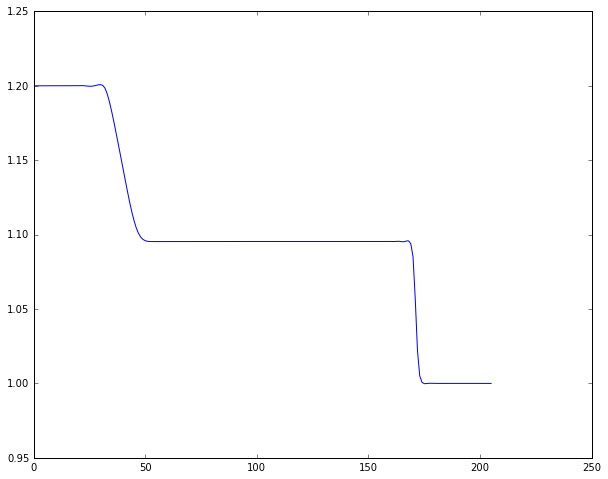

In [8]:
plot(hout[:,4])